In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from torch import nn, optim
from torch.optim import lr_scheduler
from PIL import Image
from tempfile import TemporaryDirectory
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from torchvision import datasets, transforms, models

# Data augmentation and normalization for training and testing
data_transforms = {
    'Training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation((-7,7)), 
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/kaggle/input/brain-tumor-classification-mri'


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Training', 'Testing']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['Training', 'Testing']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}

class_names = image_datasets['Training'].classes


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



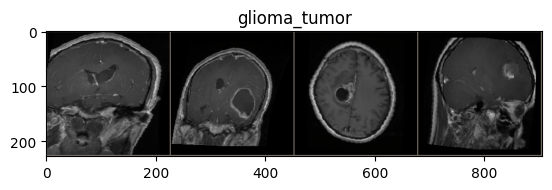

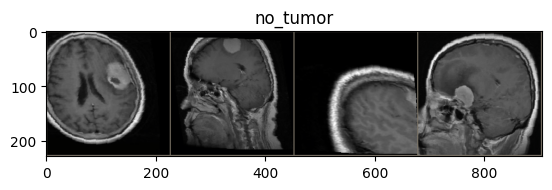

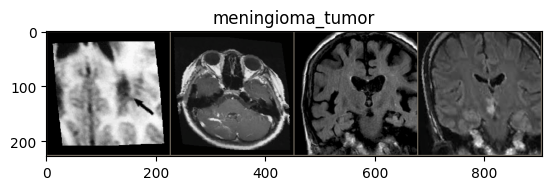

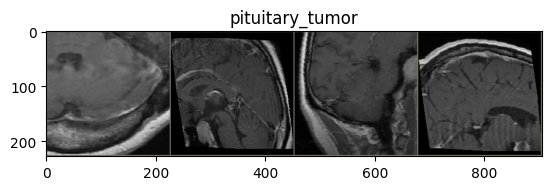

In [2]:
#Defining the Visualization function

import torchvision
import matplotlib.pyplot as plt

def imshow(inp, title=None, save_path=None):
    """Display and save image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    if save_path is not None:
        plt.savefig(save_path)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.close()  

def show_class_images(dataloader, class_names, num_images=4):
    for class_name in class_names:
        images = []
        count = 0
        for inputs, classes in dataloader:
            for i, label in enumerate(classes):
                if class_names[label] == class_name and count < num_images:
                    images.append(inputs[i])
                    count += 1
            if count == num_images:
                break
        out = torchvision.utils.make_grid(images)
        save_path = f'/kaggle/working/{class_name}_images.png' 
        imshow(out, title=class_name, save_path=save_path)


inputs, classes = next(iter(dataloaders['Training']))
show_class_images(dataloaders['Training'], ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor'])

In [2]:

def train_model_with_cv(model, criterion, optimizer, scheduler, early_stopping=None, num_epochs=25, k_folds=5):
    since = time.time()
    best_acc = 0.0
    epochs_no_improve = 0
    best_epoch = 0
    best_model_params = None

    # Split the dataset into k folds
    fold_datasets = torch.utils.data.random_split(image_datasets['Training'], [len(image_datasets['Training']) // k_folds] * k_folds)

    for fold, fold_data in enumerate(fold_datasets):
        print(f'Fold {fold+1}/{k_folds}')
        print('-' * 10)

        # Initialize the model, optimizer, and scheduler for each fold
        model_ft = models.resnet50(pretrained=True)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, len(class_names))
        model_ft = model_ft.to(device)

        optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

        fold_dataloader = torch.utils.data.DataLoader(fold_data, batch_size=4, shuffle=True, num_workers=4)

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['Training', 'Testing']:
                if phase == 'Training':
                    model_ft.train()
                else:
                    model_ft.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in fold_dataloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer_ft.zero_grad()

                    with torch.set_grad_enabled(phase == 'Training'):
                        outputs = model_ft(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'Training':
                            loss.backward()
                            optimizer_ft.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'Training':
                    scheduler.step()

                epoch_loss = running_loss / len(fold_data)
                epoch_acc = running_corrects.double() / len(fold_data)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'Testing' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_epoch = epoch
                    best_model_params = model_ft.state_dict()

                    if early_stopping is not None:
                        epochs_no_improve = 0
                elif phase == 'Testing':
                    if early_stopping is not None:
                        epochs_no_improve += 1
                        if epochs_no_improve >= early_stopping:
                            print("Early stopping!")
                            break  # Break out of inner loop to proceed to the next fold

            print()

        print(f'Fold {fold+1} best val Acc: {best_acc:4f} at epoch {best_epoch}')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    return model_ft, best_model_params  # Return both the model and the best model parameters


In [3]:
# Initialize the pretrained ResNet50 model
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Transfer the model to GPU if available
model_ft = model_ft.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train the model with cross validation
model_ft, best_model_params = train_model_with_cv(model_ft, criterion, optimizer_ft, exp_lr_scheduler, early_stopping=3, num_epochs=30, k_folds=1)

# Save the best model parameters
torch.save(best_model_params, 'best_model_params.pt')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1/1
----------
Epoch 0/29
----------
Training Loss: 1.0077 Acc: 0.6052


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Testing Loss: 1.0361 Acc: 0.6854

Epoch 1/29
----------
Training Loss: 0.7518 Acc: 0.7188
Testing Loss: 0.3545 Acc: 0.8770

Epoch 2/29
----------
Training Loss: 0.6351 Acc: 0.7756
Testing Loss: 0.3536 Acc: 0.8805

Epoch 3/29
----------
Training Loss: 0.5216 Acc: 0.8132
Testing Loss: 0.3512 Acc: 0.8739

Epoch 4/29
----------
Training Loss: 0.4934 Acc: 0.8153
Testing Loss: 0.3001 Acc: 0.8979

Epoch 5/29
----------
Training Loss: 0.4263 Acc: 0.8533
Testing Loss: 0.2758 Acc: 0.9000

Epoch 6/29
----------
Training Loss: 0.4098 Acc: 0.8610
Testing Loss: 0.2206 Acc: 0.9237

Epoch 7/29
----------
Training Loss: 0.4027 Acc: 0.8620
Testing Loss: 0.3327 Acc: 0.8941

Epoch 8/29
----------
Training Loss: 0.3475 Acc: 0.8704
Testing Loss: 0.3355 Acc: 0.8850

Epoch 9/29
----------
Training Loss: 0.3473 Acc: 0.8829
Testing Loss: 0.2591 Acc: 0.9000
Early stopping!

Epoch 10/29
----------
Training Loss: 0.3035 Acc: 0.8930
Testing Loss: 0.1731 Acc: 0.9296

Epoch 11/29
----------
Training Loss: 0.3016 Acc:

In [6]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

test_dataloader = torch.utils.data.DataLoader(image_datasets['Testing'], batch_size=4, shuffle=False, num_workers=4)

y_true, y_pred = evaluate_model(model_ft, test_dataloader)

accuracy = accuracy_score(y_true, y_pred)

f1 = f1_score(y_true, y_pred, average='weighted')

precision = precision_score(y_true, y_pred, average='weighted')

recall = recall_score(y_true, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)


Accuracy: 0.766497461928934
F1 Score: 0.7367590950675494
Precision: 0.8312658363924038
Recall: 0.766497461928934


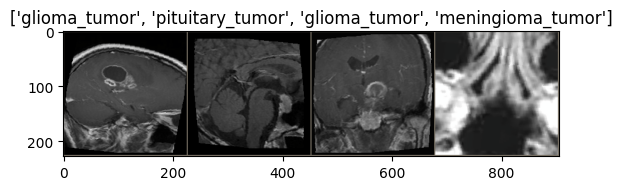

In [4]:
# Defining the Visualization function
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Getting a batch of training data
inputs, classes = next(iter(dataloaders['Training']))

# Making a grid from batch
out = torchvision.utils.make_grid(inputs)

# Let's show them with their titles of class names
imshow(out, title=[class_names[x] for x in classes])



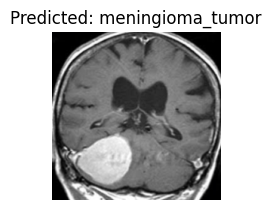

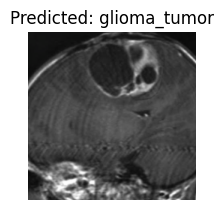

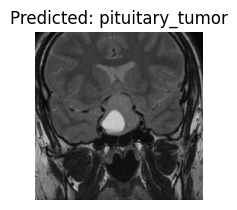

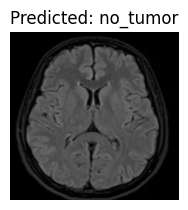

In [5]:
# Visualization of model predictions
def visualize_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['Testing'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2, 2, 1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

# Make predictions for sample images
sample_images = [
    '/kaggle/input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(14).jpg',
    '/kaggle/input/brain-tumor-classification-mri/Testing/glioma_tumor/image(25).jpg',
    '/kaggle/input/brain-tumor-classification-mri/Testing/pituitary_tumor/image(15).jpg',
    '/kaggle/input/brain-tumor-classification-mri/Testing/no_tumor/image(100).jpg'
]

for img_path in sample_images:
    visualize_model_predictions(model_ft, img_path)
    plt.ioff()
    plt.show()